### Парсинг файлов

Каждая папка будет считываться по отдельности

In [30]:
import os

def get_messages(dir):
    res = []
    for file in os.listdir(dir):
        with open(f'{dir}/{file}') as f:
            subject, _ , text = f.readlines()
            subject = ' '.join(subject.split()[1:])
            res.append((subject, text, 'legit' if 'legit' in file else 'spam'))
    return res

Здесь получим все сообщения из всех папок, у каждого сообщения отдельно есть поля `subject, text, class == legit, part`

In [31]:
messages = []

for part in os.listdir('messages'):
    messages.extend(map(lambda x: x + (part, ), get_messages(f'messages/{part}')))

In [32]:
import pandas as pd

X = pd.DataFrame(messages, columns=['subject', 'text', 'target', 'part'])
X

,subject,text,target,part
0,14486,14486 80 196 64 1896 8962 14328 2130 16502 921...,spam,part1
1,12091 16398 21903 1408 62 2547 10546 3295 2410,86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 8...,spam,part1
2,2056 118 4053 47,19071 80 2176 13472 9669 180 22481 6308 61 405...,spam,part1
3,1692 17345 10936 2130 9131 14544 2008 14471 22...,16735 16721 2843 1835 16857 76 76 76 76 76 76 ...,spam,part1
4,23340 1967 12372 1967 130 23172 9887,19054 7634 1847 2130 6049 130 9887 2130 20010 ...,legit,part1
...,...,...,...,...
1085,2056 118 11457 17524 15836 68 11521 47 47 47 4...,16733 19054 118 6306 118 86 86 17212 84 1672 8...,legit,part9
1086,4053 4074 4532,10179 1968 15193 1812 17345 21366 16502 17154 ...,spam,part9
1087,2056 118 21215 1662 1835 10470,284 13383 80 127 24731 2328 2130 130 21196 84 ...,legit,part9
1088,20787,183 180 205 205 191 214 227 219 180 219 190 22...,legit,part9


<Axes: >

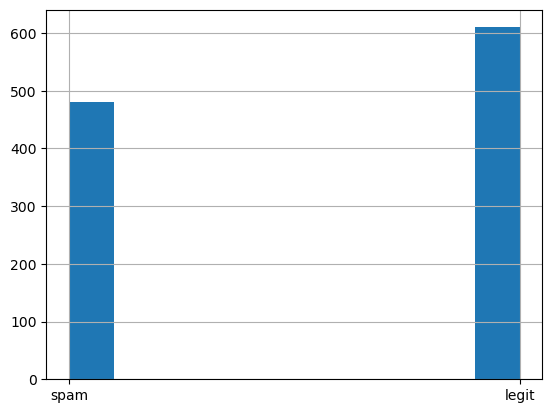

In [33]:
X['target'].hist()

Для любого предложения создаем n-грамм (упорядоченная последовательность слов), и для каждого subject и text создаем разреженный вектор.

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def vectorize_data(X_, columns, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer(lowercase=False, ngram_range=(1, 3))
        vectorizer.fit(pd.concat([X_[col] for col in columns], axis=0))
    return np.array([vectorizer.transform(X_[col]).toarray() for col in columns]).transpose((1, 0, 2)), vectorizer

In [35]:
text_columns = ['subject', 'text']
(data, vectorizer), target = vectorize_data(X, text_columns), X['target']

In [36]:
class SpamClassifier:
    def __init__(self, alpha=1.0, pos_penalty=0.5, neg_penalty=0.5, pos_label=None):
        self.alpha = alpha
        self.lambda_ = np.array([pos_penalty, neg_penalty])
        self.pos_label = pos_label

    def fit(self, X, y):
        self.is_fitted_ = True
        self.classes_ = np.unique(y)
        if self.classes_[0] != self.pos_label:
            self.classes_ = self.classes_[::-1]
        n_classes, n = len(self.classes_), X.shape[-1]

        self.class_log_prior_ = np.log(np.array([(y == c).mean() for c in self.classes_]))
        self.feature_log_prob_ = np.zeros((n_classes, 2, n))
        
        for i, class_ in enumerate(self.classes_):
            y_c = y == class_
            X_c = X[y_c]
            self.feature_log_prob_[i] = np.log((X_c.sum(axis=0) + self.alpha) / (y_c.shape[0] + 2 * self.alpha))

        return self
    
    def predict_log_proba(self, X):
        out = self.class_log_prior_ + \
            np.einsum('bjk,cjk->bc', X == 1, self.feature_log_prob_) - \
            np.einsum('bjk,cjk->bc', X == 0, np.log(1 + np.exp(self.feature_log_prob_)))
        return out * self.lambda_
    
    def predict(self, X):
        log_probs = self.predict_log_proba(X)
        return self.classes_[np.argmax(log_probs, axis=1)]
        

In [37]:
clf = SpamClassifier(alpha=1.0, pos_label='spam')
clf.fit(data, target)

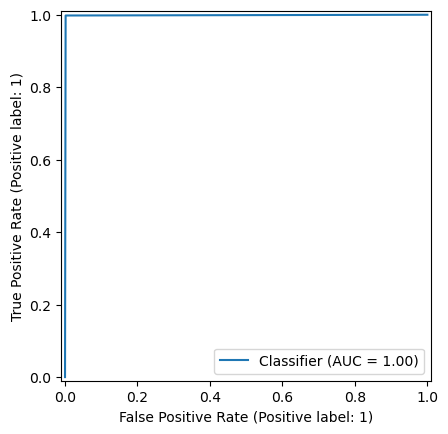

In [38]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(np.where(target == 'spam', 1, 0), 
                                 np.where(clf.predict(data) == 'spam', 1, 0))

In [39]:
X

,subject,text,target,part
0,14486,14486 80 196 64 1896 8962 14328 2130 16502 921...,spam,part1
1,12091 16398 21903 1408 62 2547 10546 3295 2410,86 86 86 86 86 86 86 86 86 86 86 86 86 86 86 8...,spam,part1
2,2056 118 4053 47,19071 80 2176 13472 9669 180 22481 6308 61 405...,spam,part1
3,1692 17345 10936 2130 9131 14544 2008 14471 22...,16735 16721 2843 1835 16857 76 76 76 76 76 76 ...,spam,part1
4,23340 1967 12372 1967 130 23172 9887,19054 7634 1847 2130 6049 130 9887 2130 20010 ...,legit,part1
...,...,...,...,...
1085,2056 118 11457 17524 15836 68 11521 47 47 47 4...,16733 19054 118 6306 118 86 86 17212 84 1672 8...,legit,part9
1086,4053 4074 4532,10179 1968 15193 1812 17345 21366 16502 17154 ...,spam,part9
1087,2056 118 21215 1662 1835 10470,284 13383 80 127 24731 2328 2130 130 21196 84 ...,legit,part9
1088,20787,183 180 205 205 191 214 227 219 180 219 190 22...,legit,part9


In [40]:
from sklearn.metrics import accuracy_score

def grid_search(**params):
    scores = []
    for part in os.listdir('messages'):
        train_data, test_data = X[X['part'] != part], X[X['part'] == part]

        X_train, y_train = vectorize_data(train_data, text_columns, vectorizer=vectorizer)[0], train_data['target']
        X_test, y_test = vectorize_data(test_data, text_columns, vectorizer=vectorizer)[0], test_data['target']

        clf = SpamClassifier(**params)
        clf.fit(X_train, y_train)
        scores.append(accuracy_score(
            np.where(y_test == 'spam', 1, 0), 
            np.where(clf.predict(X_test) == 'spam', 1, 0)
        ))
    return scores

In [41]:
for 

SyntaxError: invalid syntax (1235331270.py, line 1)